# Let's create some simple fake data

In [15]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## For the Crosstabs Example

Let's generate some fake data:

In [16]:
def gimme_data():
    
    n = 500
    k = 100
    df = pd.DataFrame()
    ids = np.arange(n)
    np.random.shuffle(ids)
    df['entity_id'] = ids
    
    # ===== Underlying features ====== 
    
    # age is random
    df['age'] = np.random.randn(len(df)) * 15 + 45
    df.loc[df.age<0,'age'] = 1.0
    
    # gender is random
    df['gender_female'] = np.random.binomial(1, 0.6, len(df))
    
    # incident rate is random, but bi-modal
    switch = (np.random.randn(len(df)) > 0.2).astype(float)
    df['incident_rate'] = np.random.beta(5,2,len(df)) * switch + np.random.beta(1,5,len(df)) * (1-switch)
    
    # some people have a rare mutation
    df['random_feature_1'] = (np.random.randn(len(df)) > .5).astype(float)
    
    # ====== Actual risk ======
    
    # we have a latent score that determines actual risk
    df['latent_score'] = 0

    # every 30 years of age adds a risk point
    df.loc[:,'latent_score'] += df['age'] / 30

    # being male adds 1 risk points
    df.loc[df.gender_female==0, 'latent_score'] = df.loc[df.gender_female==0, 'latent_score'] + 2

    # incident rate * 2 for risk
    df['latent_score'] = df['latent_score'] + df['incident_rate'] * 2

    # if you're young, female, and have the rare mutation, you're at very high risk
    small_group = (df.age<25)&(df.gender_female==1)&(df.random_feature_1==1)
    df.loc[small_group, 'latent_score'] = df.loc[small_group, 'latent_score'] + 25

    # remember a cutoff - above this, you're positive (90th percentile)
    cutoff = np.percentile(df.latent_score, q=90)

    # make some noooooise
    df['latent_score'] = df['latent_score'] + np.random.randn(len(df)) * 1
    
    # convert latent score to true label
    df['true_label'] = df['latent_score'] > cutoff
    del df['latent_score']
    
    # ===== Distracting Features =====
    
    for idx in range(2, 15):
        df['random_feature_%d'%idx] = ((np.random.randn(len(df)) * np.random.rand()*5 + np.random.randn()*5) > 2).astype(float)
        
    # some binary ones
    for idx in range(16, 30):
        df['random_feature_%d'%idx] = np.random.randn(len(df)) * np.random.rand()*5 + np.random.randn()*5
        
    # some boring correlates of age
    for idx in range(31, 60):
        df['random_feature_%d'%idx] = df['age'] + np.random.rand()*20 + np.random.rand()*100 +\
                                                  np.random.randn(len(df))*10
    # some boring correlates of gender
    for idx in range(61, 90):
        df['random_feature_%d'%idx] = df['gender_female'] + np.random.randn(len(df)) * np.random.rand()*5
        
    df = df[['entity_id','age','gender_female','incident_rate','true_label'] + 
            [c for c in df.columns if c.startswith('random')]]
        
    return df

#### Generate train and test set

In [17]:
train = gimme_data()
test = gimme_data()

In [18]:
train.true_label.value_counts()

False    430
True      70
Name: true_label, dtype: int64

In [19]:
test.true_label.value_counts()

False    419
True      81
Name: true_label, dtype: int64

#### Let's see if the interaction term made it through:

In [20]:
small_group = (train.age<25)&(train.gender_female==1)&(train.random_feature_1==1)
train[small_group].true_label.value_counts()

True    7
Name: true_label, dtype: int64

In [21]:
small_group = (test.age<25)&(test.gender_female==1)&(test.random_feature_1==1)
test[small_group].true_label.value_counts()

True    12
Name: true_label, dtype: int64

Yup!

### Fit and Predict with an RF

In [22]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X=train.drop(['entity_id','true_label'],1),
       y=train['true_label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [23]:
preds = rf.predict_proba(test.drop(['entity_id','true_label'],1))

#### Just making sure that the RF can do something sensible: 

In [24]:
fpr, tpr, _ = roc_curve(y_true=test.true_label, y_score=preds[:,1])

In [25]:
roc_auc = auc(fpr, tpr)

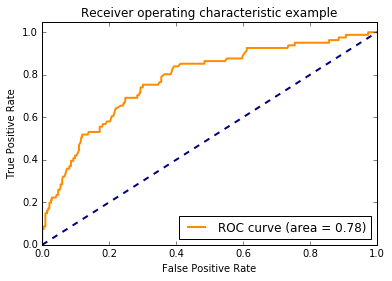

In [26]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Looking alright.

In [27]:
test['score'] = preds[:,1]

In [28]:
test = test.sort_values(by='score', ascending=False)

In [29]:
test.head(10)

,entity_id,age,gender_female,incident_rate,true_label,random_feature_1,random_feature_2,random_feature_3,random_feature_4,random_feature_5,...,random_feature_81,random_feature_82,random_feature_83,random_feature_84,random_feature_85,random_feature_86,random_feature_87,random_feature_88,random_feature_89,score
245,310,90.689034,0,0.418747,True,1.0,0.0,1.0,1.0,1.0,...,5.917597,1.436115,-1.912858,-0.569543,2.965550,-2.513481,-0.340876,-2.947102,3.077114,0.6625
64,275,58.470392,0,0.832463,True,1.0,0.0,1.0,1.0,0.0,...,-6.032877,1.128381,-1.377320,-0.008848,14.424553,-8.934291,0.814477,-1.491280,-0.161036,0.6255
266,297,50.942681,0,0.616363,True,0.0,1.0,1.0,0.0,0.0,...,-2.098788,-2.724240,-0.235813,-0.278502,-0.138277,1.596197,0.782371,-1.799455,-0.158378,0.6120
445,413,66.473848,0,0.880119,True,1.0,0.0,1.0,0.0,1.0,...,1.775662,0.749186,2.046784,-1.079093,2.349472,9.136439,-0.040463,-0.113097,4.016155,0.6095
384,80,62.094553,0,0.778579,True,0.0,1.0,1.0,0.0,1.0,...,-0.240055,0.794865,0.577040,-1.748218,3.642191,0.448044,-1.863053,-1.924604,3.214991,0.6040
395,107,60.236041,0,0.883396,True,1.0,0.0,1.0,0.0,1.0,...,-2.001680,1.419902,0.054062,-0.104972,1.504020,-2.485376,0.466229,-1.124598,-1.183533,0.6000
264,136,61.192804,0,0.180717,False,1.0,0.0,1.0,0.0,1.0,...,1.244104,0.535924,-0.983390,0.408115,3.692764,1.714156,0.167725,-4.285780,-3.440691,0.5975
391,88,58.004988,0,0.046982,False,1.0,0.0,1.0,0.0,1.0,...,1.152620,2.016372,0.003978,-0.539715,1.605834,-2.832138,-0.450334,-1.825197,-0.961031,0.5920
107,243,63.834838,0,0.706973,True,1.0,0.0,1.0,0.0,1.0,...,2.675436,1.345596,0.179549,-0.610908,-2.372196,-1.284385,-1.743944,2.596432,-0.348752,0.5845
263,188,44.427224,0,0.094704,False,1.0,1.0,1.0,1.0,1.0,...,-2.717508,-6.052413,0.221070,-1.407377,1.309400,4.311352,-2.908956,-6.742073,-1.599630,0.5840


But didn't pick up on the interaction term.

In [30]:
# rearrange columns a bit
test = test[['entity_id','true_label','score'] + [c for c in test.columns if c not in ['entity_id','true_label','score']]]

In [31]:
test.to_csv('test_data.csv', index=False)